Problem 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [2]:
income = np.loadtxt("incomes.txt")

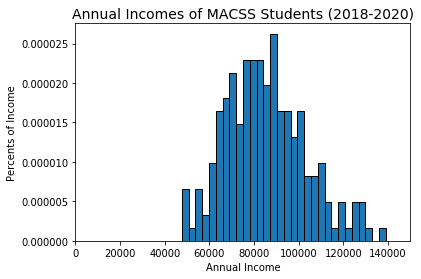

In [3]:
#a
num_bins = 30
plt.hist(income, num_bins, edgecolor = 'k', density = True)
plt.title('Annual Incomes of MACSS Students (2018-2020)', fontsize = 14)
plt.xlabel('Annual Income')
plt.ylabel('Percents of Income')
plt.xlim([0, 150000])
plt.show()

In [4]:
#b
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))
            
    pdf_vals    = (( 1 / (xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp(-(np.log(xvals) - mu) ** 2 / (2 * sigma ** 2))) /
                    prob_notcut)
    
    return pdf_vals

In [5]:
import scipy.integrate as intgr
import scipy.optimize as opt
import scipy.stats as sts

def data_moments(xvals):
    mean_data = xvals.mean()
    var_data = xvals.var()
    return mean_data, var_data

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    return mean_model, var_model

def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err    
    return crit_val

In [6]:
np.log(80000)

11.289781913656018

In [12]:
np.log(87000) - np.log(70000)

0.21741287660522524

In [14]:
mu_init = 11 #init is a problem, according to the above rough estimation
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)

gmm_args = (income, 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x

print('mu_GMM1 =', mu_GMM1, ' sig_GMM1 =', sig_GMM1)
print('The value of criterion function is {}.'.format(results.fun[0][0]))

mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
error = err_vec(income, mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2, )
print('Mean of Data =', mean_data, ', Standard Deviation of Data =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation =', std_model)
print('Error vector =', error)

mu_GMM1 = 11.336910385143259  sig_GMM1 = 0.21302707136654847
The value of criterion function is 1.4533607335636674e-15.
Mean of Data = 85276.82360625811 , Standard Deviation of Data = 323731572.2295289
Mean of model = 85276.82671665077 , Standard Deviation = 323731575.819931
Error vector = [3.64740680e-08 1.10906763e-08]


/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


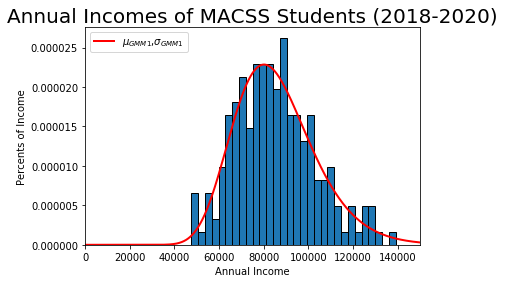

In [15]:
num_bins = 30
plt.hist(income, num_bins, edgecolor = 'k', density = True)
plt.title('Annual Incomes of MACSS Students (2018-2020)', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Percents of Income')
plt.xlim([0, 150000])

Nvec = np.linspace(0, 150000, 3000)
plt.plot(Nvec, trunc_lognorm_pdf(Nvec, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='$\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

In [16]:
#c
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    
    return Err_mat
Err_mat = get_Err_mat2(income, mu_GMM1, sig_GMM1, 0.0, 150000, False)
#Err_mat

In [17]:
VCV2 = (1 / income.shape[0]) * (Err_mat @ Err_mat.T) #1/N * E(x|mu, sigma) * E(x|mu, sigma)T
print(VCV2) #omega

import numpy.linalg as lin
W_hat2 = lin.inv(VCV2) #inverse of omega
print(W_hat2)

[[0.0445167  0.09358616]
 [0.09358616 1.94756657]]
[[24.98774342 -1.2007327 ]
 [-1.2007327   0.57115992]]


In [19]:
mu_init = mu_GMM1
sig_init = sig_GMM1
params_init = np.array([mu_init, sig_init])

gmm_args = (income, 0.0, 150000.0, W_hat2)
results_2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_2.x

In [20]:
print('mu_GMM2 =', mu_GMM2, ' sig_GMM2 =', sig_GMM2)
print('The value of criterion function is {}.'.format(results_2.fun[0][0]))

mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
error = err_vec(income, mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2, )
print('Mean of Data =', mean_data, ', Standard Deviation of Data =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation =', std_model)
print('Error vector =', error)

mu_GMM2 = 11.336910342951796  sig_GMM2 = 0.21302707728237674
The value of criterion function is 1.5524666355643554e-16.
Mean of Data = 85276.82360625811 , Standard Deviation of Data = 323731572.2295289
Mean of model = 85276.82339397445 , Standard Deviation = 323731572.2511242
Error vector = [-2.48934764e-09  6.67074240e-11]


/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


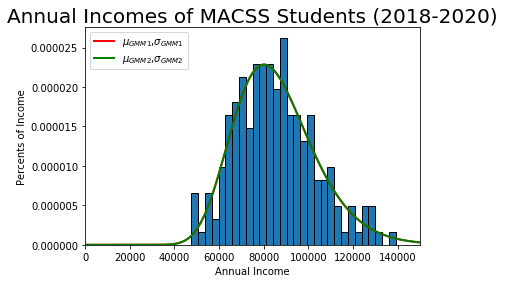

In [21]:
num_bins = 30
plt.hist(income, num_bins, edgecolor = 'k', density = True)
plt.title('Annual Incomes of MACSS Students (2018-2020)', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Percents of Income')
plt.xlim([0, 150000])

Nvec = np.linspace(0, 150000, 3000)
plt.plot(Nvec, trunc_lognorm_pdf(Nvec, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='$\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

plt.plot(Nvec, trunc_lognorm_pdf(Nvec, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='g', label='$\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')
plt.show()

In [22]:
#d
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [23]:
def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (income, 0.0, 150000.0, W_hat1_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
print("The value of criterion function is", results_3.fun[0][0])

mu_GMM1_3= 11.336726659453136  sig_GMM1_3= 0.21174632289626155
The value of criterion function is 2.3818173783923146e-05


/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


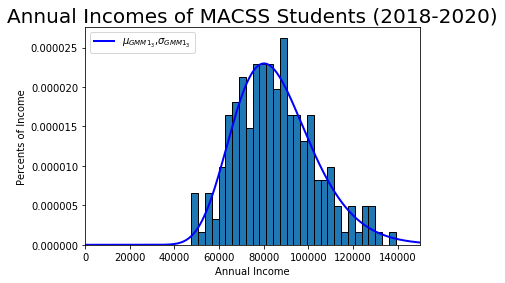

In [24]:
num_bins = 30
plt.hist(income, num_bins, edgecolor = 'k', density = True)
plt.title('Annual Incomes of MACSS Students (2018-2020)', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Percents of Income')
plt.xlim([0, 150000])

Nvec = np.linspace(0, 150000, 3000)
plt.plot(Nvec, trunc_lognorm_pdf(Nvec, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth=2, color='b', label='$\mu_{GMM1_3}$,$\sigma_{GMM1_3}$')
plt.legend(loc='upper left')
plt.show()

In [25]:
bpct_1_model1_3, bpct_2_model1_3, bpct_3_model1_3 = model_moments3(mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0)
bpct_1_dat1_3, bpct_2_dat1_3, bpct_3_dat1_3 = data_moments3(income)
err1_3 = err_vec3(income, mu_GMM1_3, sig_GMM1_3, 0.0, 150000, simple=True).reshape(3, )
print('Percent(<75000) in data: {:.2f}%, Percent(75000-100000) in data: {:.2f}%, Percent(>100000) in data: {:.2f}%'
      .format(100 * bpct_1_dat1_3, 100 * bpct_2_dat1_3, 100 * bpct_3_dat1_3))
print('Percent(<75000) in model: {:.2f}%, Percent(75000-100000) in model: {:.2f}%, Percent(>100000) in model: {:.2f}%\n'
      .format(100 * bpct_1_model1_3, 100 * bpct_2_model1_3, 100 * bpct_3_model1_3))
print(f'The difference between data and model moments are {err1_3}.')

Percent(<75000) in data: 30.00%, Percent(75000-100000) in data: 50.00%, Percent(>100000) in data: 20.00%
Percent(<75000) in model: 29.93%, Percent(75000-100000) in model: 49.81%, Percent(>100000) in model: 19.97%

The difference between data and model moments are [-0.00072765 -0.00194235 -0.0003373 ].


In [26]:
#e
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    return Err_mat

In [28]:
Err_mat3 = get_Err_mat3(income, mu_GMM1, sig_GMM1, 0.0, 150000.0, True)
VCV2_3 = (1 / income.shape[0]) * (Err_mat3 @ Err_mat3.T)
W_hat2_3 = lin.pinv(VCV2_3)

mu_init = mu_GMM1_3
sig_init = sig_GMM1_3
params_init = np.array([mu_init, sig_init])
gmm_args = (income, 0.0, 150000.0, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)
print("The value of criterion function is", results2_3.fun[0][0])

mu_GMM2_3= 11.336511327986104  sig_GMM2_3= 0.21392038241220113
The value of criterion function is 0.0006825293968706411


/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/zhouanqi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


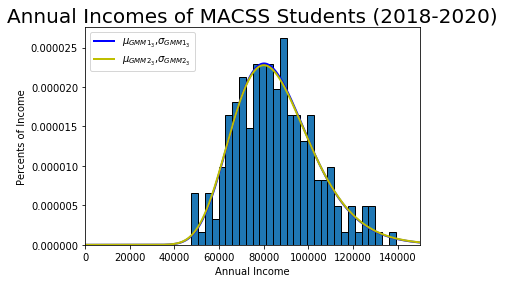

In [29]:
num_bins = 30
plt.hist(income, num_bins, edgecolor = 'k', density = True)
plt.title('Annual Incomes of MACSS Students (2018-2020)', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Percents of Income')
plt.xlim([0, 150000])

Nvec = np.linspace(0, 150000, 3000)
plt.plot(Nvec, trunc_lognorm_pdf(Nvec, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth=2, color='b', label='$\mu_{GMM1_3}$,$\sigma_{GMM1_3}$')
plt.legend(loc='upper left')

Nvec = np.linspace(0, 150000, 3000)
plt.plot(Nvec, trunc_lognorm_pdf(Nvec, mu_GMM2_3, sig_GMM2_3, 0.0, 150000),
         linewidth=2, color='y', label='$\mu_{GMM2_3}$,$\sigma_{GMM2_3}$')
plt.legend(loc='upper left')

plt.show()

In [30]:
bpct_1_model2_3, bpct_2_model2_3, bpct_3_model2_3 = model_moments3(mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0)
bpct_1_dat2_3, bpct_2_dat2_3, bpct_3_dat2_3 = data_moments3(income)
err2_3 = err_vec3(income, mu_GMM2_3, sig_GMM2_3, 0.0, 150000, simple=True).reshape(3, )
print('Percent(<75000) in data: {:.2f}%, Percent(75000-100000) in data: {:2f}%, Percent(>100000) in data: {:2f}%'
      .format(100 * bpct_1_dat2_3, 100 * bpct_2_dat2_3, 100 * bpct_3_dat2_3))
print('Percent(<75000) in model: {:.2f}%, Percent(75000-100000) in model: {:.2f}%, Percent(>100000) in model: {:.2f}%\n'
      .format(100 * bpct_1_model2_3, 100 * bpct_2_model2_3, 100 * bpct_3_model2_3))
print(f'The difference between data and model moments are {err2_3}.')

Percent(<75000) in data: 30.00%, Percent(75000-100000) in data: 50.000000%, Percent(>100000) in data: 20.000000%
Percent(<75000) in model: 30.15%, Percent(75000-100000) in model: 49.37%, Percent(>100000) in model: 20.15%

The difference between data and model moments are [ 0.001484   -0.00626293  0.00151557].


In [31]:
#f
GMM_value=[results.fun[0][0], results_2.fun[0][0], results_3.fun[0][0],results2_3.fun[0][0]]
GMM_value

[1.4533607335636674e-15,
 1.5524666355643554e-16,
 2.3818173783923146e-05,
 0.0006825293968706411]

By comparing the value of GMM criterion function for each method, we can conclude that the estimation result from part (c) fits the data most, which is using mean and std as two moments with two-step optimal weighting matrix. It has the least GMM criterion function value.

Problem 2:

In [34]:
#a
import pandas as pd
data = pd.read_csv("sick.txt").astype('float64')
N = data.shape[0]

def err_vec(data, beta0, beta1, beta2, beta3):
    yhat = beta0 + beta1 * data['age']+ beta2 * data['children'] + beta3 * data['avgtemp_winter']
    y = data['sick']
    err_vec = yhat - y
    err_vec = np.array(err_vec)
    
    return err_vec

def criterion(params, *args):
    beta0, beta1, beta2, beta3 = params
    data, W = args
    err = err_vec(data, beta0, beta1, beta2, beta3)
    crit_val = err.T @ W @ err
    
    return crit_val

beta0, beta1, beta2, beta3 = 1, 0, 0, 0
params_init = np.array([beta0, beta1, beta2, beta3])
W_hat = np.eye(N)
gmm_args = (data, W_hat)
results = opt.minimize(criterion, params_init, args = (gmm_args), tol = 1e-14, method = 'L-BFGS-B')
beta0, beta1, beta2, beta3 = results.x

print("beta0 =", beta0)
print("beta1 =", beta1)
print("beta2 =", beta2)
print("beta3 =", beta3)
print('The value of criterion function is', results.fun)

beta0 = 0.2516448636180223
beta1 = 0.012933469667256711
beta2 = 0.40050098511048643
beta3 = -0.009991708483433188
The value of criterion function is 0.00182128980560192
